# Google Colab Set up to Load Dataset

Run this if working in a Google Colab

In [1]:
!git clone https://github.com/jasonjabbour/Diffusion_Planning.git

fatal: destination path 'Diffusion_Planning' already exists and is not an empty directory.


In [1]:
%cd Diffusion_Planning

/home/jason/Desktop/Jason/Diffusion/Diffusion_Planning


In [2]:
!ls

Captures	    Modeling	  README.md
Diffusion_Planning  PathPlanning  requirements.txt


# Load Dependencies

In [3]:
import torch
import pandas as pd
import numpy as np
import json
import os
import math
import matplotlib.pyplot as plt
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter
import torchvision.models as models
from torchvision import transforms
from torchinfo import summary

# Data Preparation

In [4]:
class PathPlanningDataset(Dataset):
    def __init__(self, csv_file, map_dir, transform=None):
        self.path_data = pd.read_csv(csv_file)
        self.map_dir = map_dir
        self.transform = transform
        self.pair_ids = self.path_data['pair_id'].unique()
        self.max_path_length = self.find_max_path_length()

    def find_max_path_length(self):
        # Find the maximum length among all RRT and A* paths
        max_length = 0
        for pair_id in self.pair_ids:
            astar_path = self.path_data[(self.path_data['pair_id'] == pair_id) & (self.path_data['algo'] == 'A*')]
            max_length = max(max_length, len(astar_path))
        return max_length

    def pad_with_eos(self, path_tensor, max_length):
        padded_path = torch.full((max_length, 2), -1.0)  # Using -1.0 as the EOS token
        length = path_tensor.size(0)
        padded_path[:length] = path_tensor
        return padded_path

    def __len__(self):
        return len(self.pair_ids)

    def __getitem__(self, idx):
        pair_id = self.pair_ids[idx]
        # Load map data
        map_path = os.path.join(self.map_dir, f'map_{pair_id}.json')
        with open(map_path, 'r') as f:
            map_data = json.load(f)

        # Load path data
        astar_path = self.path_data[(self.path_data['pair_id'] == pair_id) & (self.path_data['algo'] == 'A*')][['x', 'y']].values

        # Extracting start and end points
        start_point = astar_path[0]
        end_point = astar_path[-1]

        # Convert paths to PyTorch tensors
        astar_tensor = torch.tensor(astar_path, dtype=torch.float32)
        # Convert map to tensor
        map_tensor = torch.tensor(map_data, dtype=torch.float32)
        # Convert start_point, end_point to tensors
        start_point_tensor = torch.tensor(start_point, dtype=torch.float32)
        end_point_tensor = torch.tensor(end_point, dtype=torch.float32)

        # Pad paths with the EOS token to ensure consistent length
        astar_tensor = self.pad_with_eos(astar_tensor, self.max_path_length)

        # Create a mask for valid points in the path
        astar_mask = (astar_tensor[:, 0] != -1.0)

        return {'map': map_tensor, 'astar_path': astar_tensor, 'astar_mask': astar_mask, 'start_point': start_point_tensor, 'end_point': end_point_tensor}


def collate_fn(batch):
    maps = [item['map'] for item in batch]
    astar_paths = [item['astar_path'] for item in batch]
    astar_masks = [item['astar_mask'] for item in batch]
    start_point = [item['start_point'] for item in batch]
    end_point = [item['end_point'] for item in batch]

    # Stack the sequences
    maps_stacked = torch.stack(maps)
    astar_padded = torch.stack(astar_paths)
    astar_masks = torch.stack(astar_masks)  # Stack masks
    start_points_stacked = torch.stack(start_point)
    end_points_stacked = torch.stack(end_point)

    return {'map': maps_stacked, 'astar_path': astar_padded, 'astar_mask': astar_masks, 'start_point': start_points_stacked, 'end_point': end_points_stacked}

def create_dataset(csv_file, map_dir, val_size=.1):

    train_size = 1 - val_size

    assert (train_size + val_size) == 1
    
    # Initialize the full dataset
    full_dataset = PathPlanningDataset(csv_file=csv_file, map_dir=map_dir)

    # Generate shuffled indices
    indices = np.random.permutation(len(full_dataset))

    # Calculate split sizes
    train_end = int(train_size * len(full_dataset))

    # Split indices for training and validation
    train_indices = indices[:train_end]
    val_indices = indices[train_end:]

    # Create subset datasets
    train_dataset = Subset(full_dataset, train_indices)
    val_dataset = Subset(full_dataset, val_indices)

    return train_dataset, val_dataset

# Initialize datasets
train_dataset, val_dataset = create_dataset(csv_file='PathPlanning/path_data/path_data_astar.csv', map_dir='PathPlanning/map_data', val_size=.1)

# DataLoader setup
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

Test the data loader

In [5]:
# To test the dataloader, you can iterate over it
for i, data in enumerate(train_loader):
    print(f"Batch {i}")
    print(data['map'].shape, data['astar_path'].shape, data['astar_mask'].shape, data['start_point'].shape, data['end_point'].shape)
    break

Batch 0
torch.Size([32, 100, 100]) torch.Size([32, 175, 2]) torch.Size([32, 175]) torch.Size([32, 2]) torch.Size([32, 2])


In [6]:
print(f"Number of unique paths and maps: {len(train_dataset) + len(val_dataset)}")

Number of unique paths and maps: 1000


Merge Path and Map Function

In [7]:
def modify_map_with_path(map_matrix, path, mask=None, highlight_indices=None):
    """
    Modify map_matrix with the given path, excluding coordinates where mask is False.

    Args:
    - map_matrix (np.ndarray): The map as a 2D numpy array.
    - path (list of tuples): The path as a list of (x, y) coordinates.
    - mask (np.ndarray, optional): A boolean array of the same shape as map_matrix.
                                   If provided, only the coordinates where mask is True
                                   will be marked.

    Returns:
    - np.ndarray: The modified map.


    Maps are (100,100) matrices that have 4 values.

    0: White-space no obstacle
    1: Obstacle
    2: Start
    3: End
    4: Path

    """
    modified_map = np.copy(map_matrix)
    index = 0
    for (x, y) in path:
        if 0 <= x < modified_map.shape[1] and 0 <= y < modified_map.shape[0]:
            # If a mask is provided and the mask value is False, skip marking this coordinate
            if mask is not None and not mask[index]:
                continue

            current_value = modified_map[int(y), int(x)]
            # Avoid overwriting start (2) and end (3) points
            if current_value not in {2, 3}:
                # Check if this index should be highlighted
                if (highlight_indices is not None) and (index in highlight_indices):
                    modified_map[int(y), int(x)] = 5  # Mark the path as highlighted
                else:
                    modified_map[int(y), int(x)] = 4  # Mark the path normally

        index+=1

    return modified_map

In [8]:
def apply_custom_colors(map_data):
    # Define RGB colors
    color_map = {
        0: [1, 1, 1],       # White space (no obstacle)
        1: [0, 0, 0],       # Obstacles (black)
        2: [1, 0, 0],       # Start point (red)
        3: [0, 1, 0],       # End point (green)
        4: [0.5, 0.5, 0.5], # Path (grey)
        5: [0, 0, 1]        # Highlighted path (blue)
    }
    
    # Initialize an empty RGB image
    rgb_image = np.zeros((*map_data.shape, 3))
    
    # Apply colors
    for value, color in color_map.items():
        rgb_image[map_data == value] = color
    
    return rgb_image

Visualize Merged Path and Map

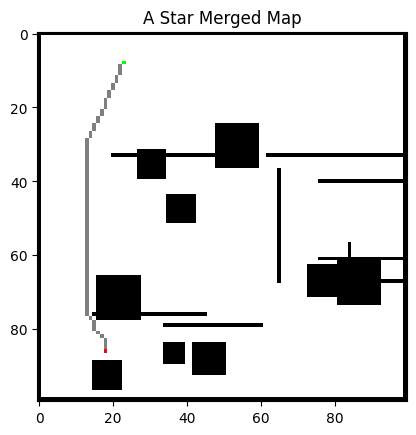

In [38]:
# Get a batch of data
data = next(iter(train_loader))
maps = data['map']

# Modify the maps with the RRT paths
modified_maps = []
for i in range(maps.size(0)):
    astar_modified_map = modify_map_with_path(maps[i].numpy(), data['astar_path'][i].numpy(), data['astar_mask'][i].numpy())
    # astar_modified_map = modify_map_with_path(maps[i].numpy(), [], data['astar_mask'][i].numpy())

    break

# Apply custom colors
colored_map_image = apply_custom_colors(astar_modified_map.squeeze())

# Visualize the first generated map
plt.imshow(colored_map_image)
plt.title("A Star Merged Map")
plt.show()

# Modeling

## Extract Feature Embeddings from Maps using Resnet

Map Preprocessing Function

In [10]:
def preprocess_maps(maps):
    # Resize maps and adjust channels for ResNet
    # ResNet expects 3-channel images, but your maps are 1-channel.
    # You need to repeat the channels to make it 3-channel, and also resize to at least 224x224 as expected by ResNet.
    # Check if maps is missing a spatial dimension

    # Check if maps already include a batch dimension
    if maps.dim() == 3:  # Shape is (N, H, W), typical for batched grayscale images
        maps = maps.unsqueeze(1)  # Add a channel dimension: (N, 1, H, W)
    elif maps.dim() == 2:  # Single image (H, W)
        maps = maps.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions: (1, 1, H, W)
    elif maps.dim() == 4 and maps.size(1) == 1:  # Already in (N, C, H, W) format
        pass  # No need to change anything if already properly shaped
    else:
        raise ValueError("Unexpected map dimensions. Expected (H, W), (N, H, W), or (N, C, H, W) with C=1")

    # Resize maps to the expected input size of the ResNet (224x224) and repeat the single channel to simulate 3 channels
    maps_resized = torch.nn.functional.interpolate(maps, size=(224, 224), mode='bilinear', align_corners=False)
    maps_resized = maps_resized.repeat(1, 3, 1, 1)  # Repeat the channel dimension to create 3-channel images

    return maps_resized

Load ResNet Feature Extractor

In [11]:
# Load the pretrained ResNet model
pretrained_resnet18_model = models.resnet18(pretrained=True)

# Remove the fully connected layer to use the model as a feature extractor
resnet18_feature_extractor = nn.Sequential(*list(pretrained_resnet18_model.children())[:-1])

/home/jason/anaconda3/envs/diffusion_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jason/anaconda3/envs/diffusion_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Example showing embeddings for input

In [12]:
# Iterate over the DataLoader (process only the first batch for demonstration)
for i, batch in enumerate(train_loader):
    maps, astar_paths = batch['map'], batch['astar_path']

    # Resize maps for the resnet model
    maps_resized = preprocess_maps(maps)

    # Forward pass through the modified model to get the embeddings
    embeddings = resnet18_feature_extractor(maps_resized)

    break

# Check the shape of the output embeddings
print(embeddings.shape)

torch.Size([32, 512, 1, 1])


# Diffusion Model

In [13]:
# Check if CUDA is available and set the device accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda:0


Build Diffusion Model Architecture


In [39]:
class DiffusionModel:
    def __init__(self, start_schedule=0.0001, end_schedule=0.01, timesteps = 150):
        # start_schedule: starting value for beta scheduling
        self.start_schedule = start_schedule
        # end_schedule: ending value for beta scheduling
        self.end_schedule = end_schedule
        # timesteps: number of timesteps in the diffusion process
        self.timesteps = timesteps

        """
        if
            betas = [0.1, 0.2, 0.3, ...]
        then
            alphas = [0.9, 0.8, 0.7, ...]
            alphas_cumprod = [0.9, 0.9 * 0.8, 0.9 * 0.8, * 0.7, ...]


        """
        # Create an array of beta values linearly spaced between start and end schedules
        self.betas = torch.linspace(start_schedule, end_schedule, timesteps)
        # Compute alpha values as 1 minus the corresponding beta values
        self.alphas = 1 - self.betas
        # Compute the cumulative product of alphas to use in diffusion calculations
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        # Scaling factor for noise
        self.noise_scale = 20.0

    def forward(self, x_0, t, mask, device):
        """
        Simulate the forward diffusion process (noising)

        x_0: original path data (Batch, Channel, Height, Width)
        t: timestep indices for the diffusion (Batch,)
        mask: Boolean tensor indicating valid path points.
        """
        # Generate noise with the same shape as the input data
        noise = torch.randn_like(x_0) * self.noise_scale
        # Get the square root of alphas_cumprod for the given timesteps
        sqrt_alphas_cumprod_t = self.get_index_from_list(self.alphas_cumprod.sqrt(), t, x_0.shape)
        # Get the square root of (1 - alphas_cumprod) for the given timesteps
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x_0.shape)

        # Calculate the mean of the diffusion process at time t
        mean = sqrt_alphas_cumprod_t.to(device) * x_0.to(device)
        # Calculate the variance contribution from the noise
        variance = sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device)

        # Calculate final noisy output, ensuring EOS (-1) tokens remain unchanged
        noisy_output = mean + variance
        noisy_output = torch.where(mask.unsqueeze(-1).to(device), noisy_output, torch.full_like(noisy_output, -1.0))

        # Return the noisy version of the input along with the generated noise
        return noisy_output, noise.to(device)


    @torch.no_grad()
    def backward(self, x, t, map_embeddings, start_points, end_points, model, sparse_path=None):
        """
        Simulate the reverse diffusion process (denoising)

        Calls the model to predict the noise in the path and returns
        the denoised path.
        Applies noise to this path, if we are not in the last step yet.

        x: current noisy path
        t: timestep indices
        model: model used to estimate the original noise in the path
        """

        # Get model predictions for noise at each timestep
        predicted_noise = model(x, map_embeddings, start_points, end_points, t, sparse_path)
        
        # Extract the beta value for each timestep
        betas_t = self.get_index_from_list(self.betas, t, x.shape)
        # Compute necessary components for the denoising step
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x.shape)
        sqrt_recip_alphas_t = self.get_index_from_list(torch.sqrt(1.0 / self.alphas), t, x.shape)

        # Calculate the mean of the denoised image
        mean = sqrt_recip_alphas_t * (x - betas_t * predicted_noise / sqrt_one_minus_alphas_cumprod_t)
        posterior_variance_t = betas_t

        # Add noise only if not the last timestep
        if (t > 0).all():
            noise = torch.randn_like(x)
            variance = torch.sqrt(posterior_variance_t) * noise
            return mean + variance
        else:
            return mean

    @staticmethod
    def get_index_from_list(values, t, x_shape):
        batch_size = t.shape[0]
        """
        Static method to extract values from a tensor based on indices
        and reshape the result to match input dimensions

        pick the values from vals
        according to the indices stored in `t`
        """
        # Gather the values from `values` tensor at indices provided by `t`
        result = values.gather(-1, t.cpu())
        """
        if
        x_shape = (5, 3, 64, 64)
            -> len(x_shape) = 4
            -> len(x_shape) - 1 = 3

        and thus we reshape `out` to dims
        (batch_size, 1, 1, 1)

        """
        # Reshape the result to match the input dimensions for broadcasting
        return result.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)



In [40]:
class MultiLevelDiffusionModel:
    def __init__(self, levels, start_schedules, end_schedules, timesteps_per_level):
        self.levels = levels
        self.models = [
            DiffusionModel(start_schedule=start_schedules[i], end_schedule=end_schedules[i], timesteps=timesteps_per_level[i])
            for i in range(levels)
        ]

    def forward(self, x_0, level, t, mask, device):
        return self.models[level].forward(x_0, t, mask, device)

    def backward(self, level, x, t, map_embeddings, start_points, end_points, model, sparse_path=None):
        return self.models[level].backward(x, t, map_embeddings, start_points, end_points, model, sparse_path)

In [41]:
# Helper function to get a sample map and path
def get_sample_map_and_path(dataset):
    sample_data = next(iter(DataLoader(dataset, batch_size=1, shuffle=True)))
    return sample_data['map'].squeeze(0), sample_data['astar_path'].squeeze(0), sample_data['astar_mask'].squeeze(0), sample_data['start_point'].squeeze(0)

In [42]:
def resample_path(batch_path_tensor, batch_mask_tensor, target_length=100):
    """
    Resample a batch of path tensors to a uniform number of points based on valid points indicated by a mask.

    This function processes each path in the batch individually, using linear interpolation over the indices
    of valid path points to create a uniformly sampled path with a specified number of waypoints.
    The mask is used to filter out invalid points, ensuring only relevant data points are included in the resampling process.
    A new mask is generated where all entries are `True` since all resampled points are considered valid.

    Args:
        batch_path_tensor (torch.Tensor): A batch of path tensors of shape [batch_size, sequence_length, num_features].
        batch_mask_tensor (torch.Tensor): A batch of boolean masks of shape [batch_size, sequence_length].

    Returns:
        uniform_paths (torch.Tensor): The batch of resampled path tensors with `target_length` waypoints.
        new_masks (torch.Tensor): Batch of boolean tensors of size [batch_size, target_length] with all True values.
    """
    batch_size = batch_path_tensor.size(0)
    num_features = batch_path_tensor.size(2)

    # Initialize tensor to hold resampled paths and new masks
    uniform_paths = torch.empty(batch_size, target_length, num_features, dtype=batch_path_tensor.dtype, device=batch_path_tensor.device)
    # Create a new mask (all true because all are valid sampled points)
    new_masks = torch.ones(batch_size, target_length, dtype=torch.bool, device=batch_path_tensor.device)

    for i in range(batch_size):
        path_tensor = batch_path_tensor[i]
        mask_tensor = batch_mask_tensor[i]

        # Only consider valid points as per the mask
        valid_points = path_tensor[mask_tensor]

        if len(valid_points) == 0:
            # If no valid points, handle edge case (e.g., by filling with zeros or repeating last valid point)
            uniform_paths[i] = torch.zeros((target_length, num_features), dtype=path_tensor.dtype, device=path_tensor.device)
        else:
            # Calculate the indices for uniform sampling
            indices = torch.linspace(0, len(valid_points) - 1, target_length, dtype=torch.long, device=batch_path_tensor.device)

            # Sample the points uniformly
            uniform_paths[i] = valid_points[indices]

    return uniform_paths, new_masks

In [43]:
def select_closest_and_furthest_points(noisy_paths, start_points, num_points, device):
    """
    Selects the closest 'num_points' to the 'start_points' from 'noisy_paths' and identifies the remaining points as the furthest.
    
    Args:
        noisy_paths (torch.Tensor): Tensor of shape [batch_size, 2, sequence_length] containing noisy path data.
        start_points (torch.Tensor): Tensor of shape [batch_size, 2] containing start points for each path.
        num_points (int): Number of closest points to select.
        device (torch.device): Device on which to perform the computations.
    
    Returns:
        tuple: A tuple containing:
            - closest_points (torch.Tensor): The subset of points closest to the start points.
            - closest_indices (torch.Tensor): The indices of these closest points in the original noisy_paths tensor.
            - furthest_points (torch.Tensor): The remaining points after selecting the closest points.
            - furthest_indices (torch.Tensor): The indices of these remaining points in the original noisy_paths tensor.
    """
    noisy_paths = noisy_paths.to(device)
    start_points = start_points.to(device)

    # Calculate the differences for each point in noisy_paths with the start_points
    differences = noisy_paths - start_points.unsqueeze(-1)  # Expanding start_points for broadcasting

    # Compute the Euclidean distance from start points
    distances = torch.sqrt(torch.sum(differences ** 2, dim=1))

    # Find the indices of the closest 'num_points' distances
    _, closest_indices = torch.topk(distances, num_points, largest=False, dim=-1)

    # Select the corresponding closest points using the indices
    closest_points = torch.gather(noisy_paths, 2, closest_indices.unsqueeze(1).expand(-1, 2, -1))

    # Create a mask to identify the remaining points
    full_indices = torch.arange(distances.size(-1), device=device).expand_as(distances)
    furthest_mask = torch.ones_like(distances, dtype=torch.bool)
    furthest_mask.scatter_(1, closest_indices, False)

    # Use the mask to select the furthest points
    furthest_indices = full_indices[furthest_mask].view(distances.size(0), -1)
    furthest_points = torch.gather(noisy_paths, 2, furthest_indices.unsqueeze(1).expand(-1, 2, -1))

    return closest_points, closest_indices, furthest_points, furthest_indices


In [44]:
# Example usage
batch_size = 5
sequence_length = 175
num_points = 50  # Number of closest points to select, assume this comes from target_lengths[level]

# Simulate data
noisy_paths = torch.rand(batch_size, 2, sequence_length)
start_points = torch.rand(batch_size, 2)

# Call the function
closest_points, closest_indices, furthest_points, furthest_indices= select_closest_and_furthest_points(noisy_paths, start_points, num_points, device)

print("Closest Points Shape:", closest_points.shape)  # Should be [batch_size, 2, num_points]
print("Closest Points Indices Shape:", closest_indices.shape)  # Should be [batch_size, num_points]
print("Furthest Points Shape:", furthest_points.shape)
print("Furthest Points Indices:", furthest_indices.shape)

Closest Points Shape: torch.Size([5, 2, 50])
Closest Points Indices Shape: torch.Size([5, 50])
Furthest Points Shape: torch.Size([5, 2, 125])
Furthest Points Indices: torch.Size([5, 125])


In [45]:
def calculate_schedules(initial_start, initial_end, num_levels):
    """
    Calculate the start and end schedules for diffusion models across multiple levels.

    Each subsequent level starts with the same minimum variance as the first level but ends at half
    the maximum variance of the previous level.

    Args:
    - initial_start (float): The starting variance (beta) for the first level, consistent across all levels.
    - initial_end (float): The ending variance (beta) for the first level.
    - num_levels (int): Total number of diffusion levels.

    Returns:
    - tuple of (list, list): A tuple containing two lists:
        - start_schedules: Start variances for each level.
        - end_schedules: End variances for each level, each half of the end variance of the previous level.
    """
    # Initialize the start schedules for all levels with the initial start variance
    start_schedules = [initial_start] * num_levels
    # Initialize end schedules where the first level has the initial end variance
    end_schedules = [initial_end] + [0] * (num_levels - 1)

    for level in range(1, num_levels):
        # Set the end schedule for the current level to half of the end schedule of the previous level
        end_schedules[level] = round(end_schedules[level-1] / 2, 6)

    return start_schedules, end_schedules

# Example usage
num_levels = 6
initial_start = 0.0001
initial_end = 0.01

start_schedules, end_schedules = calculate_schedules(initial_start, initial_end, num_levels)
print("Start Schedules:", start_schedules)
print("End Schedules:", end_schedules)

Start Schedules: [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001]
End Schedules: [0.01, 0.005, 0.0025, 0.00125, 0.000625, 0.000313]


Visualize forward Noising Processing and Selecting Closest Noised Points in a Receding Manner

Level 0, Path Tensor: torch.Size([1, 128, 2])
Level 1, Path Tensor: torch.Size([1, 175, 2])
Level 2, Path Tensor: torch.Size([1, 175, 2])
Level 3, Path Tensor: torch.Size([1, 175, 2])
Level 4, Path Tensor: torch.Size([1, 175, 2])
Level 5, Path Tensor: torch.Size([1, 175, 2])


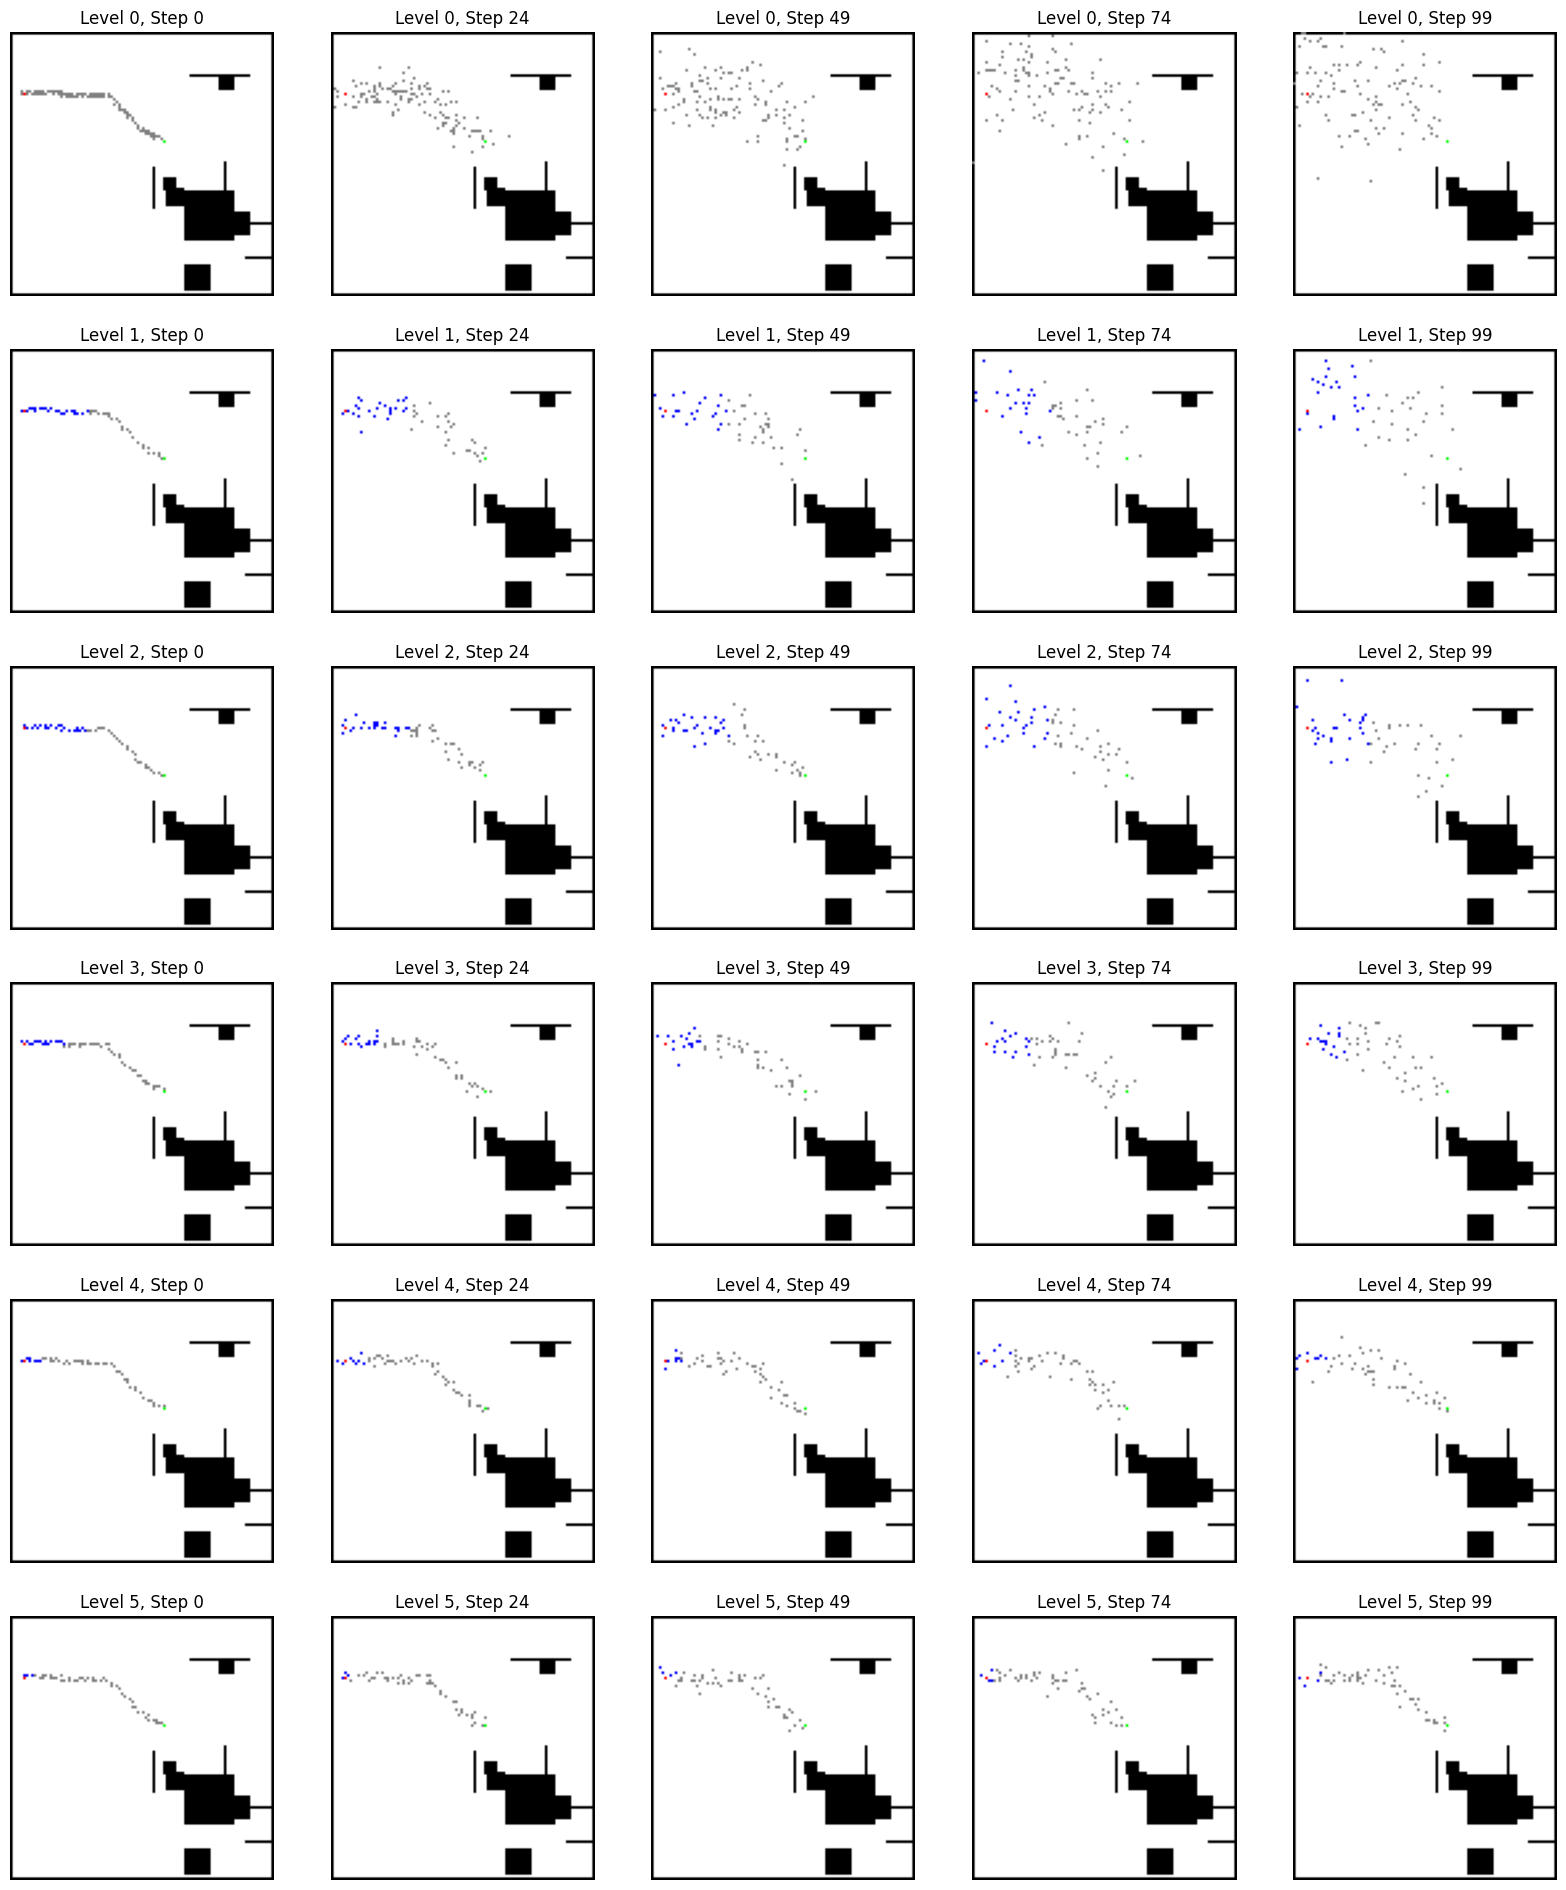

In [80]:
# Example setup for MultiLevelDiffusionModel
levels = 6
target_lengths = [128, 64, 32, 16, 8, 4]
timesteps_per_level = [100, 100, 100, 100, 100, 100]

# Initialize the MultiLevelDiffusionModel
multi_level_diffusion_model = MultiLevelDiffusionModel(levels, start_schedules, end_schedules, timesteps_per_level)

# Generate a batch of full resolution paths with reduced points for initial levels
map_tensor, path_tensor, mask_tensor, start_point_tensor = get_sample_map_and_path(train_dataset)  # Replace None with your actual dataset

# Add a batch dimension
path_tensor = path_tensor.unsqueeze(0)
mask_tensor = mask_tensor.unsqueeze(0)
start_point_tensor = start_point_tensor.unsqueeze(0)
# Visualization setup
NO_DISPLAY_IMAGES = 5
fig, axes = plt.subplots(levels, NO_DISPLAY_IMAGES, figsize=(20, 4 * levels))  # Adjust subplot creation

# Process each level
for level in range(levels):

    # Get target length of path at this level
    target_length = target_lengths[level]

    if level == 0:
        # Sample path to be target length for this level
        reduced_path_tensor, reduced_mask_tensor = resample_path(path_tensor, mask_tensor, target_length=target_length)
    else:
        reduced_path_tensor, reduced_mask_tensor = path_tensor, mask_tensor

    print(f"Level {level}, Path Tensor: {reduced_path_tensor.shape}")

    # Create a batch for visualization
    path_batch = reduced_path_tensor.repeat(NO_DISPLAY_IMAGES, 1, 1)
    t_max = (multi_level_diffusion_model.models[level].timesteps  - 1) if level > 0 else (multi_level_diffusion_model.models[level].timesteps - 1)
    t = torch.linspace(0, t_max, NO_DISPLAY_IMAGES).long()

    # Process the batch through the current level model
    noisy_path_batch, actual_noise = multi_level_diffusion_model.forward(path_batch, level, t, reduced_mask_tensor, device)
    # Permute noisy_path_batch to match [batch_size, channels, sequence_length]
    noisy_path_batch = noisy_path_batch.permute(0, 2, 1)
    # Permute to change from torch.Size([32, 175, 2]) to torch.Size([32, 2, 175])
    actual_noise = actual_noise.permute(0, 2, 1)
    
    if level > 0:
        # Select the points closest to the start point after adding noise
        closest_points, closest_indices, _, _ = select_closest_and_furthest_points(noisy_path_batch, start_point_tensor, target_lengths[level], device)
        # Select the corresponding noise applied to these closest points
        # indices need to be expanded to match the channel dimension in actual_noise, which is 2
        indices_expanded = closest_indices.unsqueeze(1).expand(-1, actual_noise.size(1), -1)
        # Now gather along the last dimension (dimension of 175 data points)
        actual_noise_subselected = torch.gather(actual_noise, 2, indices_expanded)

    else:
        closest_points = noisy_path_batch

    noisy_path_batch = noisy_path_batch.permute(0,2,1)

    # Visualization for each timestep in the current level
    for image_i, noisy_path in enumerate(noisy_path_batch):
        # Convert tensor back to numpy for plotting
        noisy_path_np = noisy_path.cpu().numpy()
        modified_map = np.copy(map_tensor.numpy())  # Assuming the whole map is needed for context

        if level > 0: 
            # Modify map with path
            noised_path_modified_map = modify_map_with_path(modified_map, noisy_path_np, reduced_mask_tensor.squeeze(), closest_indices[image_i])
        else:
            noised_path_modified_map = modify_map_with_path(modified_map, noisy_path_np, reduced_mask_tensor.squeeze())

        # Plotting in the correct axis
        ax = axes[level, image_i] if levels > 1 else axes[image_i]  # Handle single level case

        # Apply custom colors
        colored_map = apply_custom_colors(noised_path_modified_map)
        ax.imshow(colored_map)

        ax.set_title(f"Level {level}, Step {t[image_i].item()}")
        ax.axis('off')

# plt.savefig('setup.png', dpi=300)
plt.show()


Unet

In [47]:
class SinusoidalPositionEmbeddings(nn.Module):
    """
      Class for generating sinusoidal position embeddings based on the input time step
    """
    def __init__(self, dim):
        super().__init__()
         # Dimensionality of the time embeddings
        self.dim = dim

    def forward(self, time):
        # Get the device (CPU/GPU) of the input tensor
        device = time.device
        # Divide the embedding dimension in half
        half_dim = self.dim // 2
        # Scaling factor for the embeddings
        embeddings = math.log(10000) / (half_dim - 1)
        # Generate exponential steps
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
         # Scale the steps by the input time tensor
        embeddings = time[:, None] * embeddings[None, :]
         # Apply sine and cosine
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # Return the final time embedding
        return embeddings

Sinusoidal Embeddings Example

Time step 0: Embedding: tensor([[0., 0., 0., 0., 0., 1., 1., 1., 1., 1.]])
Time step 1: Embedding: tensor([[2.4740e-01, 2.4997e-02, 2.5000e-03, 2.5000e-04, 2.5000e-05, 9.6891e-01,
         9.9969e-01, 1.0000e+00, 1.0000e+00, 1.0000e+00]])
Time step 2: Embedding: tensor([[4.7943e-01, 4.9979e-02, 5.0000e-03, 5.0000e-04, 5.0000e-05, 8.7758e-01,
         9.9875e-01, 9.9999e-01, 1.0000e+00, 1.0000e+00]])
Time step 3: Embedding: tensor([[6.8164e-01, 7.4930e-02, 7.4999e-03, 7.5000e-04, 7.5000e-05, 7.3169e-01,
         9.9719e-01, 9.9997e-01, 1.0000e+00, 1.0000e+00]])
Time step 4: Embedding: tensor([[8.4147e-01, 9.9833e-02, 9.9998e-03, 1.0000e-03, 1.0000e-04, 5.4030e-01,
         9.9500e-01, 9.9995e-01, 1.0000e+00, 1.0000e+00]])


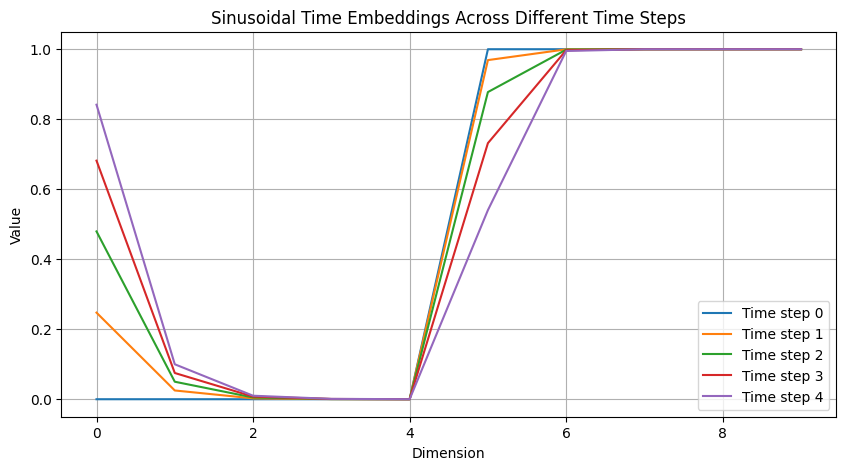

In [48]:
# Initialize the embedding generator
embedding_generator = SinusoidalPositionEmbeddings(dim=10)
# Generate time steps (for example, 5 time steps) Normalized time steps from 0 to 1
timesteps = torch.linspace(0, 1,5)
# Generate embeddings for each time step
time_embeddings = [embedding_generator.forward(timestep.unsqueeze(0)) for timestep in timesteps]

# Print the embeddings
for idx, embedding in enumerate(time_embeddings):
    print(f"Time step {idx}: Embedding: {embedding}")

plt.figure(figsize=(10, 5))
for i, embedding in enumerate(time_embeddings):
    plt.plot(embedding[0].numpy(), label=f'Time step {i}')
plt.title('Sinusoidal Time Embeddings Across Different Time Steps')
plt.xlabel('Dimension')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [49]:
class SparsePathEmbedding(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.embedding = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        # Flatten the output across the sequence length dimension
        # This assumes x is [batch_size, features, sequence_length]
        # Resulting shape will be [batch_size, features * sequence_length]
        flattened = embedded.flatten(start_dim=1)
        return flattened
    
class Block(nn.Module):
    def __init__(self, channels_in, channels_out, time_embedding_dims):
        super().__init__()
        # Time embedding module
        self.time_embedding = SinusoidalPositionEmbeddings(time_embedding_dims)
        # Kernel size for the convolutions
        kernel_size = 3
        # Padding to keep dimensions consistent
        padding = 1
        # First convolution layer
        self.conv1 = nn.Conv1d(channels_in, channels_out, kernel_size, padding=padding)
        # Second convolution layer
        self.conv2 = nn.Conv1d(channels_out, channels_out, kernel_size, padding=padding)
        # MLP for processing time embeddings
        self.time_mlp = nn.Linear(time_embedding_dims, channels_out)
        # ReLU activation function
        self.relu = nn.ReLU()

    def forward(self, x, t):
        # Apply the first convolution and activation
        x = self.relu(self.conv1(x))
        # Generate and process time embeddings
        time_emb = self.time_mlp(self.time_embedding(t))
        # Expand time embeddings to match data dimensions
        time_emb = time_emb.unsqueeze(-1).expand_as(x)
        # Add time information to the features
        x = x + time_emb
        # Apply the second convolution and activation
        x = self.relu(self.conv2(x))
        # Return the processed features
        return x

class UNet(nn.Module):
    def __init__(self, input_channels, map_emb_dims, time_embedding_dims, sparse_path_dims=None, level=0, start_end_points_dims=4):
        super().__init__()

        # Sum of input channels, map embedding dimensions, and point dimensions
        total_input_channels = input_channels + map_emb_dims + start_end_points_dims

        if sparse_path_dims:
            # Embedding size for sparse path
            sparse_path_emb_dim = 128
            # Initialize the sparse path embedding with appropriate sequence length
            self.sparse_path_embedding = SparsePathEmbedding(sparse_path_dims, sparse_path_emb_dim // 2)
            # Add the dimensions of the sparse path embedding (output from embedding layer)
            total_input_channels += sparse_path_emb_dim


        # Define channel depth based on level
        base_channels = 32  # Start with a smaller number of channels at lower levels
        # Increase number of blocks for higher levevls
        num_blocks = max(2, 7 - level)  # Ensuring at least one block

        # Generate a list of channel sizes that increases with each block
        sequence_channels = [base_channels * 2**i for i in range(num_blocks)]
        
        # Initial convolution layer
        self.conv1 = nn.Conv1d(total_input_channels, sequence_channels[0], 3, padding=1)
           
        # Create a series of Blocks for processing features
        self.blocks = nn.ModuleList([Block(sequence_channels[i], sequence_channels[i+1], time_embedding_dims) 
                                     for i in range(len(sequence_channels)-1)])
        
        # Output 2 channels for X and Y coordinates
        self.final_conv = nn.Conv1d(sequence_channels[-1], 2, 1)

        # print(f"LEVEL {level} -----------------------------")
        # print(f"num blocks {num_blocks}")
        # print(f"sequence channels {sequence_channels}")
        # print(f"blocks {self.blocks}")

    def forward(self, path_data, map_embeddings, start_points, end_points, t, sparse_path=None):
        
        # Concatinate and Repeat start and end points to match the path data dimensions [batch, points, repeated]
        start_end_points_features = torch.cat([start_points, end_points], dim=1).unsqueeze(-1).repeat(1, 1, path_data.size(2))

        # Expand and repeat map embeddings to match path data dimensions
        map_features = map_embeddings.unsqueeze(-1).repeat(1, 1, path_data.size(2))

        # If a sparse path exists for us to condition on
        if sparse_path is not None: 
            # Embed the sparse path
            embedded_sparse_path = self.sparse_path_embedding(sparse_path)
            # Expand and repeat sparse path embeddings to match path data dimensions
            embedded_sparse_path = embedded_sparse_path.unsqueeze(-1).repeat(1, 1, path_data.size(2))
            # Concatenate all features
            x = torch.cat((path_data, map_features, embedded_sparse_path, start_end_points_features), dim=1)
        else:
            # Concatenate all features
            x = torch.cat((path_data, map_features, start_end_points_features), dim=1)
                
        # Apply the initial convolution to the input
        x = self.conv1(x)
        
        # Pass the feature map through each block, incorporating the previous denoised path as conditioning
        for block in self.blocks:
            x = block(x, t)
        
        # Return the final coordinates after the last convolution
        return self.final_conv(x)


Test the Unet Model

In [50]:
# Define constants for the UNet models
map_emb_dims = 512
input_channels = 2  # XY coordinates for the path data
time_embedding_dims = 128
start_end_points_dims = 4  # Dimensions for flattened start and end points
batch_size = 32
num_levels = 6
target_lengths = [128, 64, 32, 16, 8, 4]

# Initialize lists for models and corresponding noisy paths
unet_models = []
noised_paths = []
saved_sparse_paths_dim = []

# Create UNet models for each level and initialize random noisy paths
for i in range(num_levels):
    # Condition on the furthest points denoised up until now
    sparse_path_dim = (target_lengths[0] - target_lengths[i]) if i > 0 else None
    # Save to easily use later
    saved_sparse_paths_dim.append(sparse_path_dim)
    # Initialize unet model
    unet_model = UNet(input_channels, map_emb_dims, time_embedding_dims, sparse_path_dims=sparse_path_dim, level=i, start_end_points_dims=start_end_points_dims)
    unet_models.append(unet_model.to(device))
    # Simulate noisy paths for this level with dimensions corresponding to target_lengths
    noised_path = torch.rand(batch_size, 2, target_lengths[i]).to(device)
    noised_paths.append(noised_path)

# Initialize random map embeddings and uniform time steps for all paths
map_embeddings = torch.rand(batch_size, map_emb_dims).to(device)
time_steps = torch.tensor([0.5] * batch_size).to(device)
denoised_outputs = [None] * num_levels  # To hold outputs from each level for use as conditioning in subsequent levels
# Generate random start and end points for the batch outside the loop
start_point = torch.rand(batch_size, 2).to(device)  
end_point = torch.rand(batch_size, 2).to(device)  

# Evaluate each UNet model on its corresponding level of path complexity
for i, unet_model in enumerate(unet_models):
    print(f"LEVEL {i} ------------------")
    previous_output = None
    if i > 0: 
        # Not using previous output as condition. The preivous output is the noise
        previous_output =  torch.rand(32, 2, saved_sparse_paths_dim[i]).to(device)
    # Run the UNet model for this level
    output = unet_model(noised_paths[i], map_embeddings, start_point, end_point, time_steps, previous_output)
    # Store the output for potential use in the next level
    denoised_outputs[i] = output  
    print(f"Output shape from model at level {i}: {output.shape}")

LEVEL 0 ------------------
Output shape from model at level 0: torch.Size([32, 2, 128])
LEVEL 1 ------------------
Output shape from model at level 1: torch.Size([32, 2, 64])
LEVEL 2 ------------------
Output shape from model at level 2: torch.Size([32, 2, 32])
LEVEL 3 ------------------
Output shape from model at level 3: torch.Size([32, 2, 16])
LEVEL 4 ------------------
Output shape from model at level 4: torch.Size([32, 2, 8])
LEVEL 5 ------------------
Output shape from model at level 5: torch.Size([32, 2, 4])


In [51]:
def visualize_path(num_timestep_display, original_path, path_timesteps_batch, sample_map, sample_mask, t, receded_indices=None, transformation_type="Noised"):
    fig, ax = plt.subplots(1, num_timestep_display + 1, figsize=(20, 4))

    # Plot original path
    original_modified_map = modify_map_with_path(np.copy(sample_map.cpu().numpy()), original_path.cpu().numpy(), sample_mask.cpu().numpy(), receded_indices)
    # Apply custom colors
    colored_original_modified_map = apply_custom_colors(original_modified_map)
    ax[0].imshow(colored_original_modified_map)
    ax[0].set_title("Original Path")
    ax[0].axis('off')

    # Plot transformed paths
    for idx, path in enumerate(path_timesteps_batch):
        path_np = path.cpu().numpy()
        path_modified_map = modify_map_with_path(np.copy(sample_map.cpu().numpy()), path_np, sample_mask.cpu().numpy(), receded_indices)
        color_path_modified_map = apply_custom_colors(path_modified_map)
        ax[idx + 1].imshow(color_path_modified_map)
        ax[idx + 1].set_title(f"{transformation_type} Path\nTime Step: {t[idx].item() if hasattr(t[idx], 'item') else t[idx]}")
        ax[idx + 1].axis('off')

    plt.show()

Function that will call the multiple levels and generate a path

In [60]:
def generate_plan(map, path, mask, start_point, end_point, models, target_lengths, num_levels, device, num_timestep_display=5, visualize=True):

    # Previous denoised path to be used as initial noisy to the next level
    previous_denoised_path = None 
    # Complete path keeping noisy and denoised sections
    complete_path = None
    complete_path_batch = None 
    
    # Get the map embeddings
    maps_preprocessed = preprocess_maps(map)
    map_embeddings = resnet18_feature_extractor(maps_preprocessed)
    # Flatten embeddings
    map_embeddings = map_embeddings.view(map_embeddings.size(0), -1)

    # Iterate through the levels
    for level, unet_model in enumerate(models):

        print(f"-------- Level {level} ---------")

        target_length = target_lengths[level]

        # Always resample to 128 waypoints
        reduced_path_tensor, reduced_mask_tensor = resample_path(path, mask, target_length=target_lengths[0])

        # if level == 0:
        #     # Sample path to be target length for this level
        #     reduced_path_tensor, reduced_mask_tensor = resample_path(path, mask, target_length=target_length)
        # else:
        #     reduced_path_tensor, reduced_mask_tensor = path, mask


        # --- Noising Visalization:
        if visualize: # and (level == 0):
            path_timestep_batch = reduced_path_tensor.repeat(num_timestep_display, 1, 1)

            # Define timesteps for noise addition
            t = torch.linspace(0, multi_level_diffusion_model.models[level].timesteps  - 1, num_timestep_display).long().to(device)

            noisy_path_timesteps_batch, _ = multi_level_diffusion_model.models[level].forward(path_timestep_batch, t, reduced_mask_tensor, device)

            # Display the noising process at that level
            visualize_path(num_timestep_display, reduced_path_tensor.squeeze(0), noisy_path_timesteps_batch, map.squeeze(0), reduced_mask_tensor.squeeze(0), t, transformation_type='Noised')

        # --- Denoising Process:

        # Get initial noised path
        t_max = multi_level_diffusion_model.models[level].timesteps - 1
        t_tensor = torch.tensor([t_max], device=device)

        # Get initial noisy path for this level
        initial_noisy_path, _ = multi_level_diffusion_model.models[level].forward(reduced_path_tensor.unsqueeze(0), t_tensor, reduced_mask_tensor.unsqueeze(0), device)
        current_denoised_path = initial_noisy_path.squeeze(0).permute(0,2,1)

        # Collect denoised paths at specific timesteps
        denoised_path_timesteps_batch = []
        timestep_list = []
        
        conditioned_path = None
        receded_indices = None
        if level > 0:
            # Select the points closest to the start point after adding noise
            current_denoised_path, receded_indices, furthest_points, furthest_indices= select_closest_and_furthest_points(current_denoised_path, start_point, target_lengths[level], device)
            # Condition on the furthest points 
            conditioned_path = furthest_points
                                                   
        # # Define early stopping condition for denoising based on level
        # early_stopped_tmax = t_max if level == (num_levels - 1) else t_max // 2

        # Denoise each timestep at a time in reverse
        for t in reversed(range(t_max + 1)):
            # t_tensor = torch.tensor([t], device=device)
            current_denoised_path = multi_level_diffusion_model.models[level].backward(current_denoised_path, t_tensor, map_embeddings, start_point, end_point, unet_model, sparse_path=conditioned_path)
            
            if visualize:
                # Collect paths at specific intervals to visualize
                if t % (t_max // (num_timestep_display - 1)) == 0 or t == 0:
                    timestep_list.append(t)
                    current_denoised_path_to_save = current_denoised_path.permute(0, 2, 1)
                    denoised_path_timesteps_batch.append(current_denoised_path_to_save)

            # # Break the loop if t reaches half of t_max and not the last level
            # if (t < early_stopped_tmax) and (level < num_levels - 1):
            #     break
        
        # Concatenate the denoised paths along the first dimension
        denoised_path_timesteps_batch = torch.cat(denoised_path_timesteps_batch, dim=0)

        print("original path", reduced_path_tensor.squeeze(0).shape)
        print("mask tensor", reduced_mask_tensor.shape)
        print("Noised paths", denoised_path_timesteps_batch.shape)
        # TODO: BUG Receded Indices don't label all closest points in blue correctly
        visualize_path(num_timestep_display,
                       reduced_path_tensor.squeeze(0), 
                       denoised_path_timesteps_batch, 
                       map.squeeze(0), 
                       reduced_mask_tensor.squeeze(0), 
                       timestep_list, 
                       None, # TODO: Should be the indices of the first target_length points
                       transformation_type='Denoised')


        # # --- Denoising Process:

        # # Get initial noised path
        # t_max = multi_level_diffusion_model.models[level].timesteps - 1
        # t_tensor = torch.tensor([t_max], device=device)

        # # At level 0 get noisy path
        # if level == 0: 
        #     initial_noisy_path, _ = multi_level_diffusion_model.models[level].forward(reduced_path_tensor.unsqueeze(0), t_tensor, reduced_mask_tensor.unsqueeze(0), device)
        #     current_denoised_path = initial_noisy_path.squeeze(0).permute(0,2,1)
        # else:
        #     # Otherwise use the most denoised path we've created so far 
        #     current_denoised_path = previous_denoised_path
            
        # # Collect denoised paths at specific timesteps
        # denoised_path_timesteps_batch = []
        # timestep_list = []

        # receded_indices = None
        # if level > 0:
        #     # Select the points closest to the start point after adding noise
        #     current_denoised_path, receded_indices, furthest_points, furthest_indices= select_closest_and_furthest_points(current_denoised_path, start_point, target_lengths[level], device)
            
        #     if complete_path is None:
        #         complete_path = furthest_points
        #     else:
        #         complete_path = torch.cat([complete_path, furthest_points], dim=2)

        #     # Repeat to plot on every figure
        #     complete_path_batch = complete_path.repeat(num_timestep_display, 1, 1)
                                                   
        # # Define early stopping condition for denoising based on level
        # early_stopped_tmax = t_max if level == (num_levels - 1) else t_max // 2

        # # Denoise each timestep at a time in reverse
        # for t in reversed(range(t_max + 1)):
        #     # t_tensor = torch.tensor([t], device=device)
        #     current_denoised_path = multi_level_diffusion_model.models[level].backward(current_denoised_path, t_tensor, map_embeddings, start_point, end_point, unet_model)
            
        #     if visualize:
        #         # Collect paths at specific intervals to visualize
        #         if t % (early_stopped_tmax // (num_timestep_display - 1)) == 0 or t == 0:
        #             timestep_list.append(t)
        #             current_denoised_path_to_save = current_denoised_path.permute(0, 2, 1)
        #             denoised_path_timesteps_batch.append(current_denoised_path_to_save)

        #     # Break the loop if t reaches half of t_max and not the last level
        #     if (t < early_stopped_tmax) and (level < num_levels - 1):
        #         break
            
        # # Save the denoised path at this level 
        # previous_denoised_path = current_denoised_path

        # # Concatenate the denoised paths along the first dimension
        # denoised_path_timesteps_batch = torch.cat(denoised_path_timesteps_batch, dim=0)

        # if level > 0:
        #     # Add on the completed defused paths from previous levels
        #     denoised_path_timesteps_batch = torch.cat([denoised_path_timesteps_batch, complete_path_batch.permute(0,2,1)], dim=1)

        # # TODO: BUG Receded Indices don't label all closest points in blue correctly
        # visualize_path(num_timestep_display,
        #                reduced_path_tensor.squeeze(0), 
        #                denoised_path_timesteps_batch, 
        #                map.squeeze(0), 
        #                reduced_mask_tensor.squeeze(0), 
        #                timestep_list, 
        #                receded_indices, 
        #                transformation_type='Denoised')

# Training

/home/jason/anaconda3/envs/diffusion_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jason/anaconda3/envs/diffusion_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/jason/anaconda3/envs/diffusion_env/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/

Epoch: 0 | Train Loss: 367.1548746043238 | Val Loss: 367.0934410095215
Model at level 0 saved to ../checkpoints/unet_model_level_0.pth
Model at level 1 saved to ../checkpoints/unet_model_level_1.pth
Model at level 2 saved to ../checkpoints/unet_model_level_2.pth
Model at level 3 saved to ../checkpoints/unet_model_level_3.pth
Model at level 4 saved to ../checkpoints/unet_model_level_4.pth
Model at level 5 saved to ../checkpoints/unet_model_level_5.pth
-------- Level 0 ---------


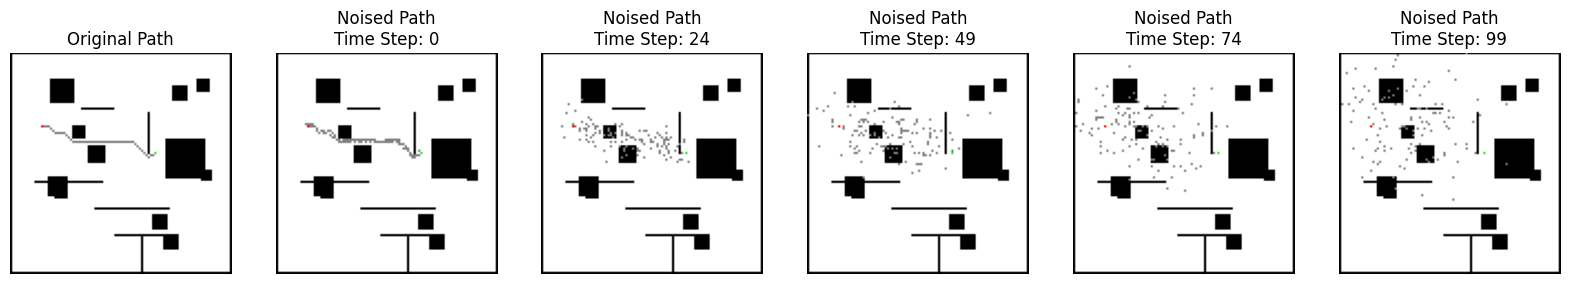

original path torch.Size([128, 2])
mask tensor torch.Size([1, 128])
Noised paths torch.Size([5, 128, 2])


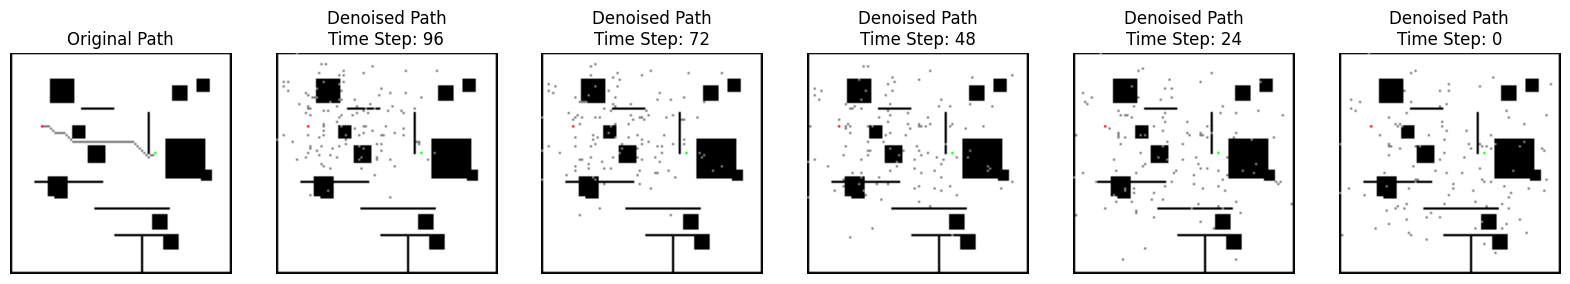

-------- Level 1 ---------


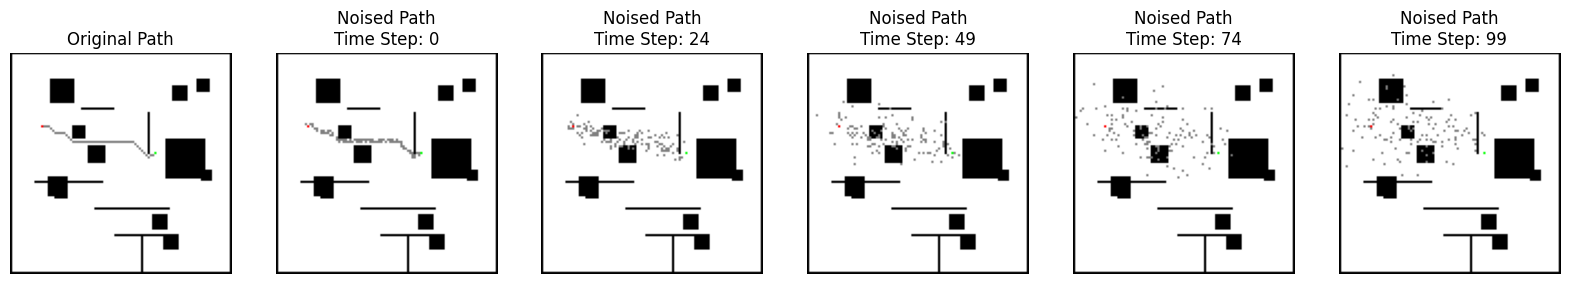

original path torch.Size([128, 2])
mask tensor torch.Size([1, 128])
Noised paths torch.Size([5, 64, 2])


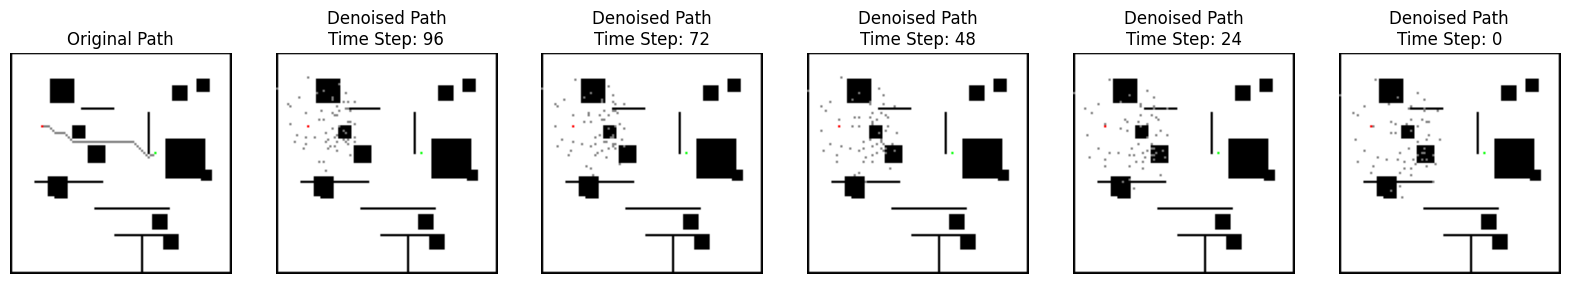

-------- Level 2 ---------


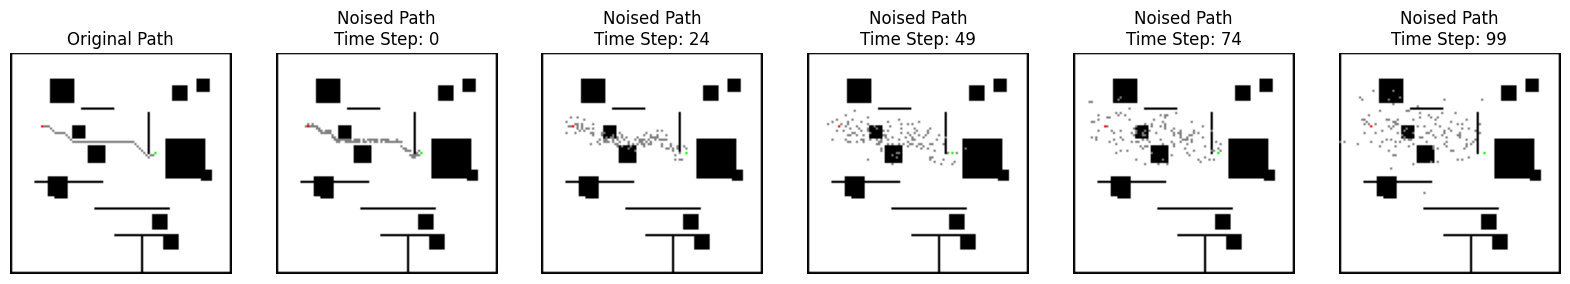

original path torch.Size([128, 2])
mask tensor torch.Size([1, 128])
Noised paths torch.Size([5, 32, 2])


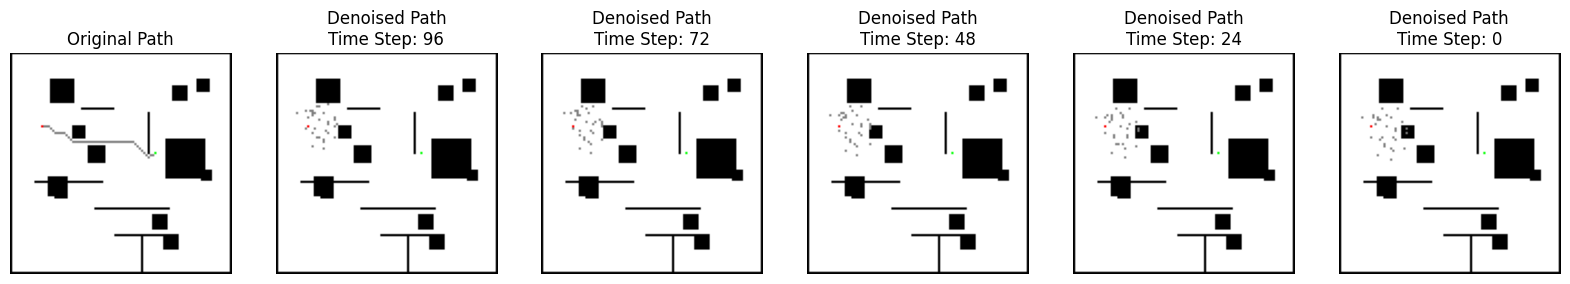

-------- Level 3 ---------


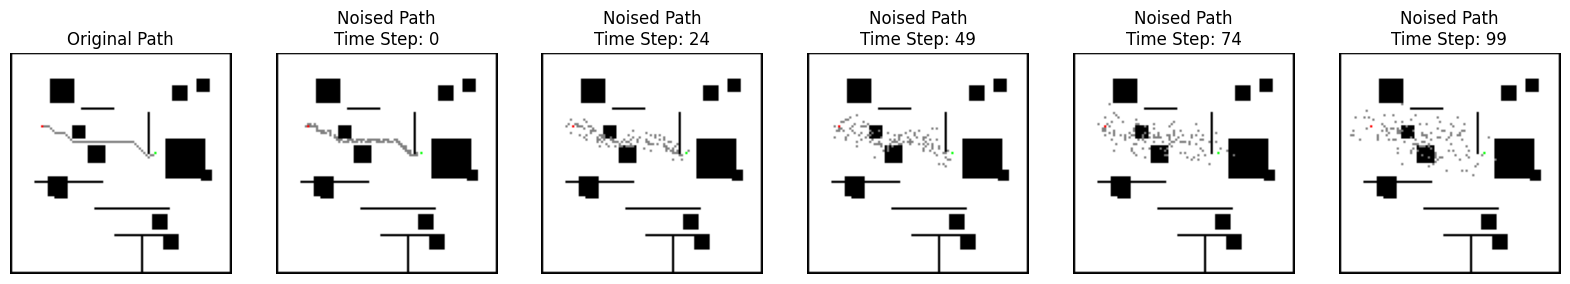

original path torch.Size([128, 2])
mask tensor torch.Size([1, 128])
Noised paths torch.Size([5, 16, 2])


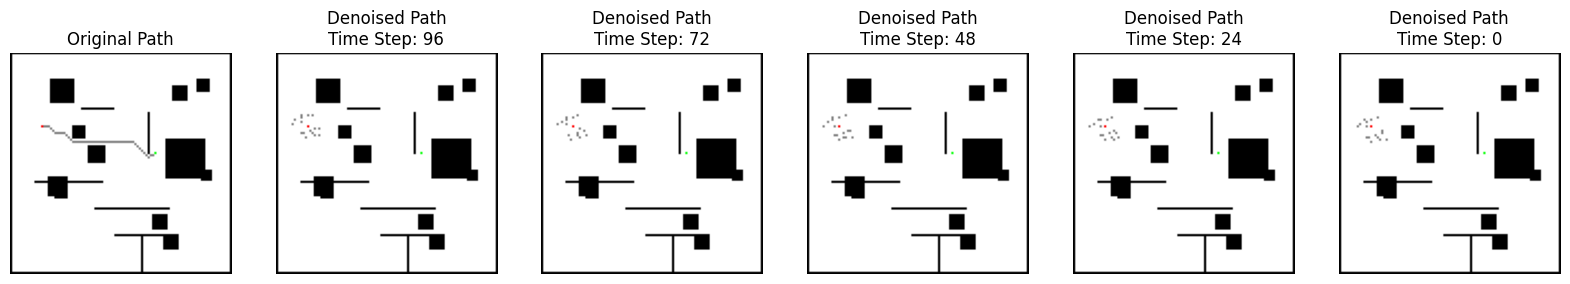

-------- Level 4 ---------


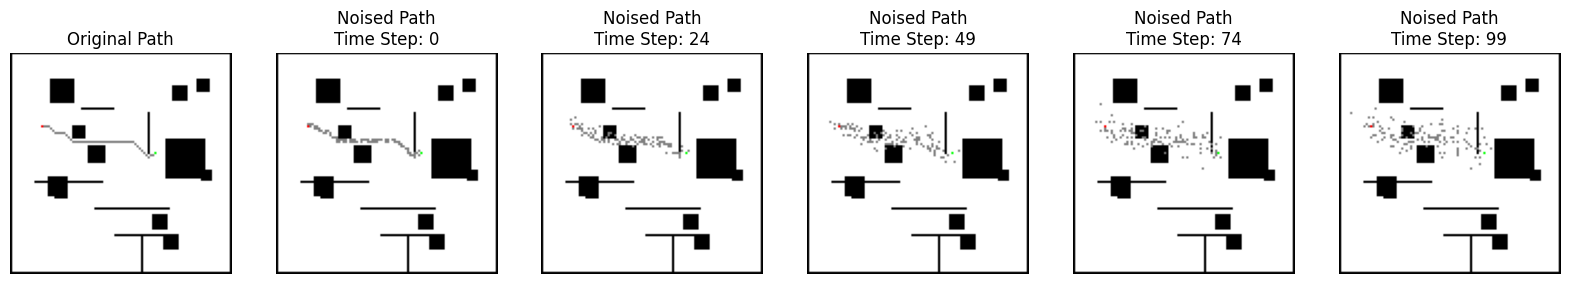

original path torch.Size([128, 2])
mask tensor torch.Size([1, 128])
Noised paths torch.Size([5, 8, 2])


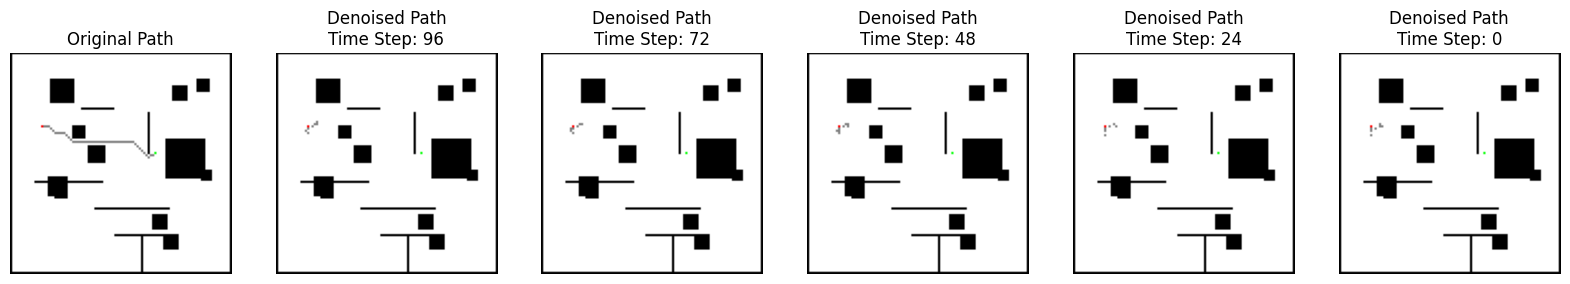

-------- Level 5 ---------


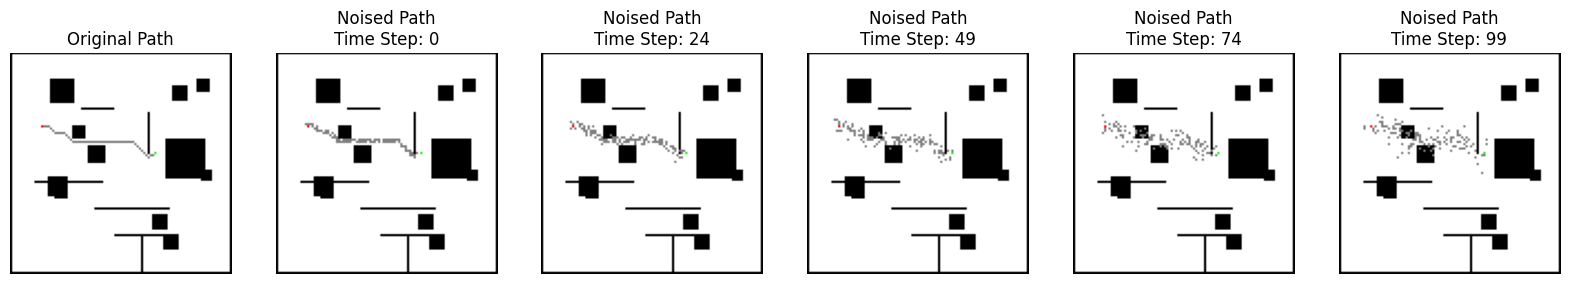

original path torch.Size([128, 2])
mask tensor torch.Size([1, 128])
Noised paths torch.Size([5, 4, 2])


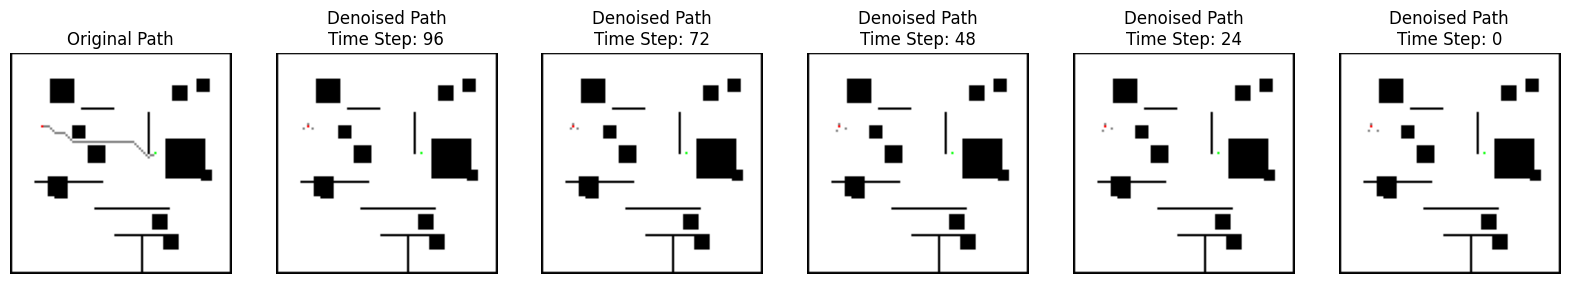

In [53]:
# Training Parameters
num_epochs = 1 # Number of epochs for training
print_frequency = 1  # Frequency of printing information
visualize_frequency = 50
save_frequency = 20

# Initialize the Unet Model
map_emb_dims = 512
input_channels = 2  # For the path data (x, y)
time_embedding_dims = 128
start_end_points_dims = 4
num_levels = 6

# Variance for first level
initial_start_variance = 0.0001
initial_end_variance = 0.01

# Calculate Schedules
start_schedules, end_schedules = calculate_schedules(initial_start_variance, initial_end_variance, num_levels)
timesteps_per_level = [100, 100, 100, 100, 100, 100]
target_lengths = [128, 64, 32, 16, 8, 4]

# Initialize multiple UNet Models and their optimizers
unet_models = []
optimizers = []

for i in range(num_levels):
    # For each level after the first, increase the input channel count to include the output from the previous level
    # Assume each U-Net outputs 2 channels, which will be used as additional inputs for the next level
    sparse_path_dim = target_lengths[0] - target_lengths[i] if i > 0 else None # Not conditioning on sparse path
    unet_model = UNet(input_channels, map_emb_dims, time_embedding_dims, sparse_path_dims=sparse_path_dim, level=i, start_end_points_dims=start_end_points_dims)
    unet_models.append(unet_model.to(device))
    optimizers.append(optim.Adam(unet_model.parameters(), lr=1e-4))

# Initialize the MultiLevelDiffusionModel
multi_level_diffusion_model = MultiLevelDiffusionModel(num_levels, start_schedules, end_schedules, timesteps_per_level)

# Load the pretrained ResNet model
pretrained_resnet18_model = models.resnet18(pretrained=True)
pretrained_resnet18_model.to(device)  # Move the model to the GPU if available

# Remove the fully connected layer to use the model as a feature extractor
resnet18_feature_extractor = nn.Sequential(*list(pretrained_resnet18_model.children())[:-1])
resnet18_feature_extractor.to(device)  # Ensure the feature extractor is also on the GPU

# Setup a small batch DataLoader for visualization
vis_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Initialize TensorBoard writer
writer = SummaryWriter("../runs/diffusion_training_loss")

def process_batch(batch,
                  unet_models, 
                  optimizers, 
                  map_embeddings_extractor, 
                  target_lengths,  
                  multi_level_diffusion_model,
                  device, 
                  train=True):
 
    maps = batch['map'].to(device)
    astar_paths = batch['astar_path'].to(device)
    astar_masks = batch['astar_mask'].to(device)
    start_point = batch['start_point'].to(device)
    end_point = batch['end_point'].to(device)
    losses = []

    # Preprocess maps and extract embeddings using a pretrained ResNet18
    maps_preprocessed = preprocess_maps(maps)
    map_embeddings = map_embeddings_extractor(maps_preprocessed)
    # Flatten embeddings
    map_embeddings = map_embeddings.view(map_embeddings.size(0), -1)
    
    for level, unet_model in enumerate(unet_models):
        # Get the optimizer for this level's model
        optimizer = optimizers[level] if train else None

        # Get target length of path at this level
        target_length = target_lengths[level]

        # No longer conditioning on a previousu path
        conditioning_path = None

        # Always resample to 128 points
        reduced_path_tensor, reduced_mask_tensor = resample_path(astar_paths, astar_masks, target_length=target_lengths[0])

        # if level == 0:
        #     # Sample path to be target length for this level
        #     reduced_path_tensor, reduced_mask_tensor = resample_path(astar_paths, astar_masks, target_length=target_length)
        # else:
        #     reduced_path_tensor, reduced_mask_tensor = astar_paths, astar_masks

        # Define the maximum timestep for noise addition
        t = torch.randint(0, multi_level_diffusion_model.models[level].timesteps - 1, (maps.size(0),)).long().to(device)

        # Get noised paths
        noisy_path_batch, actual_noise = multi_level_diffusion_model.models[level].forward(reduced_path_tensor, t, reduced_mask_tensor, device)
        # Permute noisy_path_batch to match [batch_size, channels, sequence_length]
        noisy_path_batch = noisy_path_batch.permute(0, 2, 1)
        # Permute to change from torch.Size([32, 175, 2]) to torch.Size([32, 2, 175])
        actual_noise = actual_noise.permute(0, 2, 1)
        
        # Select closest noised points
        if level > 0:
            # Select the points closest to the start point after adding noise
            closest_points, indices, furthest_points, furthest_indices = select_closest_and_furthest_points(noisy_path_batch, start_point, target_lengths[level], device)
            # Select the corresponding noise applied to these closest points
            # indices need to be expanded to match the channel dimension in actual_noise, which is 2
            indices_expanded = indices.unsqueeze(1).expand(-1, actual_noise.size(1), -1)
            # Now gather along the last dimension (dimension of 175 data points)
            actual_noise = torch.gather(actual_noise, 2, indices_expanded)
            # Condition on the furthest points
            conditioning_path = furthest_points
        else:
            closest_points = noisy_path_batch

        # Predict noise using the UNet
        predicted_noise = unet_model(closest_points, map_embeddings, start_point, end_point, t, conditioning_path)

        # Loss calculation
        loss = torch.nn.functional.mse_loss(actual_noise, predicted_noise)
        if train:
            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()

        losses.append(loss.item())

    return losses
# TODO: At some point if you put denoising in the loop and use the actual outputs of the previous model

for epoch in range(num_epochs):
    train_loss = []
    val_loss = []
    
    # Training phase
    for batch in train_loader:
        batch_loss = process_batch(batch,
                                   unet_models, 
                                   optimizers, 
                                   resnet18_feature_extractor,
                                   target_lengths, 
                                   multi_level_diffusion_model,
                                   device,
                                   train=True)
        train_loss.extend(batch_loss)

    # Validation phase
    with torch.no_grad():
        for batch in val_loader:
            batch_loss = process_batch(batch, 
                                       unet_models, 
                                       None, 
                                       resnet18_feature_extractor, 
                                       target_lengths, 
                                       multi_level_diffusion_model, 
                                       device, 
                                       train=False)
            val_loss.extend(batch_loss)

    # Logging and output
    train_avg_loss = np.mean(train_loss)
    val_avg_loss = np.mean(val_loss)
    writer.add_scalar("Training Loss", train_avg_loss, epoch)
    writer.add_scalar("Validation Loss", val_avg_loss, epoch)

    if epoch % print_frequency == 0:
        print(f"Epoch: {epoch} | Train Loss: {train_avg_loss} | Val Loss: {val_avg_loss}")

    # Saving checkpoints
    if epoch % save_frequency == 0: 
        # Save model checkpoints for each level
        for level, model in enumerate(unet_models):
            model_save_path = f"../checkpoints/unet_model_level_{level}.pth"
            torch.save(model.state_dict(), model_save_path)
            print(f"Model at level {level} saved to {model_save_path}")

    if epoch % visualize_frequency == 0:
        with torch.no_grad():
            # Sample a batch of paths for visualization
            sample_data = next(iter(vis_dataloader))
            # Squeeze to get rid of batch dimension. We only need one sample
            sample_map = sample_data['map'].to(device)
            sample_path = sample_data['astar_path'].to(device)
            sample_mask = sample_data['astar_mask'].to(device)
            sample_start_point = sample_data['start_point'].to(device)
            sample_end_point = sample_data['end_point'].to(device)

            generate_plan(sample_map, sample_path, sample_mask, sample_start_point, sample_end_point, unet_models, target_lengths, num_levels, device, num_timestep_display=5, visualize=True)
            